In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


Bad key "hatch.linewidth" on line 54 in
/home/gpleiss/.dotfiles/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 11))
y1_inds = Variable(torch.zeros(11).long())
y2_inds = Variable(torch.ones(11).long())
train_y1 = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)
train_y2 = Variable(torch.cos(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
from torch import optim
from gpytorch.kernels import RBFKernel, IndexKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-3, 3))
        self.task_covar_module = IndexKernel(n_tasks=2, rank=1)

    def forward(self,x,i):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_i = self.task_covar_module(i)
        covar_xi = covar_x.mul(covar_i)
        return GaussianRandomVariable(mean_x, covar_xi)

likelihood = GaussianLikelihood(log_noise_bounds=(-6, 6))
model = MultitaskGPModel((torch.cat([train_x.data, train_x.data]), torch.cat([y1_inds.data, y2_inds.data])),
                         torch.cat([train_y1.data, train_y2.data]), likelihood)

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

optimizer = optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)
optimizer.n_iter = 0
for i in range(50):
    optimizer.zero_grad()
    output = model(torch.cat([train_x, train_x]), torch.cat([y1_inds, y2_inds]))
    loss = -model.marginal_log_likelihood(likelihood, output, torch.cat([train_y1, train_y2]))
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()

Iter 1/50 - Loss: 1.251
Iter 2/50 - Loss: 1.340
Iter 3/50 - Loss: 1.119
Iter 4/50 - Loss: 1.108
Iter 5/50 - Loss: 1.156
Iter 6/50 - Loss: 0.989
Iter 7/50 - Loss: 1.049
Iter 8/50 - Loss: 0.956
Iter 9/50 - Loss: 0.960
Iter 10/50 - Loss: 0.977
Iter 11/50 - Loss: 0.771
Iter 12/50 - Loss: 0.705
Iter 13/50 - Loss: 0.789
Iter 14/50 - Loss: 0.700
Iter 15/50 - Loss: 0.717
Iter 16/50 - Loss: 0.516
Iter 17/50 - Loss: 0.437
Iter 18/50 - Loss: 0.672
Iter 19/50 - Loss: 0.425
Iter 20/50 - Loss: 0.484
Iter 21/50 - Loss: 0.346
Iter 22/50 - Loss: 0.443
Iter 23/50 - Loss: 0.458
Iter 24/50 - Loss: 0.458
Iter 25/50 - Loss: 0.494
Iter 26/50 - Loss: 0.474
Iter 27/50 - Loss: 0.219
Iter 28/50 - Loss: 0.391
Iter 29/50 - Loss: 0.199
Iter 30/50 - Loss: 0.381
Iter 31/50 - Loss: 0.448
Iter 32/50 - Loss: 0.405
Iter 33/50 - Loss: 0.213
Iter 34/50 - Loss: 0.444
Iter 35/50 - Loss: 0.359
Iter 36/50 - Loss: 0.398
Iter 37/50 - Loss: 0.323
Iter 38/50 - Loss: 0.548
Iter 39/50 - Loss: 0.454
Iter 40/50 - Loss: 0.338
Iter 41/5

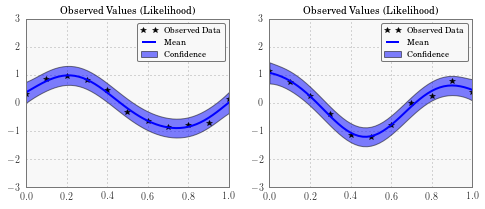

In [6]:
model.eval()
likelihood.eval()

f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))
test_x = Variable(torch.linspace(0, 1, 51))
y1_inds_test = Variable(torch.zeros(51).long())
y2_inds_test = Variable(torch.ones(51).long())

observed_pred_y1 = likelihood(model(test_x, y1_inds_test))
observed_pred_y2 = likelihood(model(test_x, y2_inds_test))

def ax_plot(ax, train_y, rand_var, title):
    lower, upper = rand_var.confidence_region()
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

ax_plot(y1_ax, train_y1, observed_pred_y1, 'Observed Values (Likelihood)')
ax_plot(y2_ax, train_y2, observed_pred_y2, 'Observed Values (Likelihood)')